<a href="https://colab.research.google.com/github/Rino04/Diamond_price_streamlit/blob/main/Diamond_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Exploration

In [ ]:
#import libaries
import pandas as pd
from xgboost import XGBRegressor
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
#load and read the df
diamond_df = pd.read_csv('/content/diamonds.csv')
diamond_df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [ ]:
#check shape
diamond_df.shape

(53940, 11)

In [ ]:
diamond_df.isna().sum()

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64

In [ ]:
#check info of df
diamond_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


# Data Preparation

In [ ]:
cols=['cut','color','clarity']
for i in cols:
  print(diamond_df[i].value_counts())

Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: cut, dtype: int64
G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: color, dtype: int64
SI1     13065
VS2     12258
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: clarity, dtype: int64


In [ ]:
# Encode the ordinal categorical variable 'cut'
cut_mapping = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
diamond_df.cut = diamond_df.cut.map(cut_mapping)

# Encoding the ordinal categorical variable 'color'
color_mapping = {'J': 0, 'I': 1, 'H': 2, 'G': 3, 'F': 4, 'E': 5, 'D': 6}
diamond_df.color = diamond_df.color.map(color_mapping)

# Encoding the ordinal cateogircal variable 'clarity'
clarity_mapping = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}
diamond_df.clarity = diamond_df.clarity.map(clarity_mapping)

In [ ]:
diamond_df = diamond_df.drop(diamond_df[diamond_df["x"]==0].index)
diamond_df = diamond_df.drop(diamond_df[diamond_df["y"]==0].index)
diamond_df = diamond_df.drop(diamond_df[diamond_df["z"]==0].index)

In [ ]:
diamond_df = diamond_df[diamond_df['depth'] < diamond_df['depth'].quantile(0.99)]
diamond_df = diamond_df[diamond_df['table'] < diamond_df['table'].quantile(0.99)]
diamond_df = diamond_df[diamond_df['x'] < diamond_df['x'].quantile(0.99)]
diamond_df = diamond_df[diamond_df['y'] < diamond_df['y'].quantile(0.99)]
diamond_df = diamond_df[diamond_df['z'] < diamond_df['z'].quantile(0.99)]

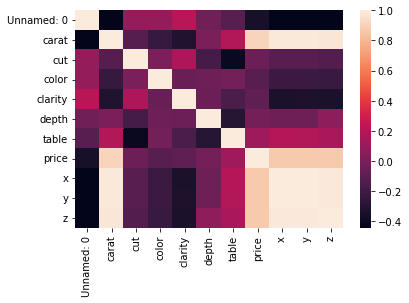

In [ ]:
diamond_df.corr()
sns.heatmap(diamond_df.corr())

# Modelling

In [ ]:
model_df = diamond_df.copy()

In [ ]:
#define X and y
X = model_df.drop(['price'], axis=1)
y = model_df['price']
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=0)


In [ ]:
xgb1 = XGBRegressor()
parameters = {
              'objective':['reg:squarederror'],
              'learning_rate': [.0001, 0.001, .01],
              'max_depth': [3, 5, 7],
              'min_child_weight': [3,5,7],
              'subsample': [0.1,0.5,1.0],
              'colsample_bytree': [0.1, 0.5, 1.0],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 3,
                        n_jobs = -1,
                        verbose=0)

xgb_grid.fit(X_train, y_train)

xgb_cv = (xgb_grid.best_estimator_)

eval_set = [(X_train, y_train),
            (X_val, y_val)]

fit_model = xgb_cv.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    eval_metric='mae',
    early_stopping_rounds=50,
    verbose=False)

print("MAE:", mean_absolute_error(y_val, fit_model.predict(X_val)))
print("MSE:", mean_squared_error(y_val, fit_model.predict(X_val)))
print("R2:", r2_score(y_val, fit_model.predict(X_val)))

# Building the App